In [1]:
#import prerequisite
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from music21 import converter, instrument, note, chord, stream, chord, midi, tempo
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-01-05 10:48:15.548531: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import pickle
file= open("/home/sparkbrains/Deepti/notes", "rb")
notes= pickle.load(file)
len(notes)

11807

In [ ]:
#create notes from 400 midi files
def data_extraction():
    notes = []
    for file in tqdm(glob.glob("..../midi_data/*.mid")):
        midi = converter.parse(file)
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)
        if parts: # file has instrument parts
            notes_to_parse = parts.parts[0].recurse()
        else: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
      
    return notes

    

In [3]:
# notes= data_extraction()

print("Total Notes: ", len(notes))
# unique notes
n_vocab= len(set(notes))
print("Unique Notes: ",n_vocab)
# get all pitch names
pitchnames = sorted(set(item for item in notes))

Total Notes:  11807
Unique Notes:  230


In [4]:
# create network_input and output
def Create_sequence(pitchnames, n_vocab):
    sequence_length = 50

    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)
    network_output = to_categorical(network_output)
    return(network_input, network_output)



In [5]:
network_input, network_output = Create_sequence(pitchnames, n_vocab)
#split data into 80-20%
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(network_input, network_output, test_size= 0.2, random_state= 1)
X_test.shape, Y_test.shape, X_train.shape, Y_train.shape, network_input.shape[1], network_input.shape[2], network_output.shape, network_input.shape 


((2352, 50, 1),
 (2352, 230),
 (9405, 50, 1),
 (9405, 230),
 50,
 1,
 (11757, 230),
 (11757, 50, 1))

In [24]:
# LSTM MODEL
def Model_training_LSTM(input_shape= (X_train.shape[1], X_train.shape[2])):
    model= keras.Sequential()
    model.add(layers.LSTM(756, activation= "relu", input_shape= input_shape))
    model.add(layers.Dropout(rate= 0.1 ))
    model.add(layers.Dense(512, activation= "relu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(n_vocab, activation= "softmax"))
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate= 0.1), metrics=["accuracy"])
    model.summary()

In [ ]:
# GRU MODEL
def Model_training_GRU(input_shape= (X_train.shape[1], X_train.shape[2])):
    model= keras.Sequential()
    model.add(layers.GRU(756, activation= "relu", input_shape= (X_train.shape[1], X_train.shape[2])))

    model.add(layers.Dropout(rate= 0.1 ))
    model.add(layers.Dense(512, activation= "relu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(n_vocab, activation= "softmax"))
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate= 0.1), metrics=["accuracy"])
    model.summary()
    
   


In [ ]:
# Hybrid MODEL
def Model_training_Hybrid(input_shape= (X_train.shape[1], X_train.shape[2])):
    model = tf.keras.Sequential([tf.keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2])),
            tf.keras.layers.LSTM(1024,activation= "relu", return_sequences=True),  
            tf.keras.layers.Dropout(0.1),                                          
            tf.keras.layers.GRU(756, activation= "relu",return_sequences=True),    
            tf.keras.layers.Dropout(0.1),                                         
            tf.keras.layers.Bidirectional(LSTM(512, activation= "relu")),          
            tf.keras.layers.BatchNormalization(),                                  
            tf.keras.layers.Dropout(0.1),                                          
            tf.keras.layers.Dense(512, activation = "relu"),                      
            tf.keras.layers.Dropout(0.1),  
            tf.keras.layers.Dense(756, activation = "relu"),                       
            tf.keras.layers.Dropout(0.1),  
                                                   
            tf.keras.layers.Dense(n_vocab, activation = "softmax")                
        ])
    model.compile(loss='categorical_crossentropy',  optimizer=tf.keras.optimizers.SGD(learning_rate= 0.1), metrics = ["accuracy"])
    model.summary()
    
    


In [26]:
# function call for lstm model
Model_training_LSTM(input_shape= (X_train.shape[1], X_train.shape[2]))

In [27]:
#function calling for GRU model
Model_training_GRU(input_shape= (X_train.shape[1], X_train.shape[2]))

In [28]:
#function callig for Hybrid model
Model_training_Hybrid(input_shape= (X_train.shape[1], X_train.shape[2]))

### LOSS GRAPH & ACCURACY GRAPH

In [3]:
df1= pd.read_csv("/home/sparkbrains/Deepti/History_LSTM.csv")
df2= pd.read_csv("/home/sparkbrains/Deepti/history_hybrid.csv")
df3= pd.read_csv("/home/sparkbrains/Deepti/History_GRU.csv")
df1= df1.drop(columns="Unnamed: 0")
df2= df2.drop(columns="Unnamed: 0")
df3= df3.drop(columns="Unnamed: 0")

df1 = df1.rename({ "loss": "losslstm", "accuracy": "accuracylstm","val_loss": "val_losslstm","val_accuracy" :"val_accuracylstm"}, axis=1)

df2 = df2.rename({ "loss": "losshybrid","accuracy": "accuracyhybrid", "val_loss" :"val_losshybrid","val_accuracy" :"val_accuracyhybrid"}, axis=1)

df3 = df3.rename({"loss" :"lossgru", "accuracy": "accuracygru", "val_loss" :"val_lossgru","val_accuracy": "val_accuracygru"}, axis=1)

pdList = [df1, df2, df3]  # List of your dataframes
df = pd.concat(pdList, axis=1)
df

,losslstm,accuracylstm,val_losslstm,val_accuracylstm,accuracy*100,val_accuracy*100,losshybrid,accuracyhybrid,val_losshybrid,val_accuracyhybrid,Accuracy*100,val_accuracy*100,lossgru,accuracygru,val_lossgru,val_accuracygru,accuracy*100,val_accuracy*100
0,5.157572,0.034769,4.854850,0.064201,3.476874,6.420068,4.997688,0.054652,4.218421,0.051871,5.465178,5.187075,5.164637,0.035619,4.840562,0.064201,3.561935,6.420068
1,4.423103,0.057735,4.318863,0.064201,5.773525,6.420068,4.047487,0.053163,4.150531,0.041667,5.316321,4.166667,4.438218,0.062307,4.307169,0.065476,6.230728,6.547619
2,4.090411,0.060287,4.153924,0.041241,6.028708,4.124150,3.969658,0.056672,4.067216,0.064201,5.667198,6.420068,4.090962,0.068368,4.157993,0.051446,6.836789,5.144558
3,3.976575,0.063052,4.097818,0.064201,6.305157,6.420068,3.934254,0.059755,4.050260,0.051446,5.975545,5.144558,3.987192,0.068368,4.087728,0.064201,6.836789,6.420068
4,3.931640,0.059224,4.055202,0.067177,5.922382,6.717687,3.908516,0.059755,4.041494,0.065051,5.975545,6.505102,3.936284,0.062307,4.054182,0.051020,6.230728,5.102041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.250896,0.913238,6.079923,0.258503,91.323763,25.850341,0.064620,0.979479,8.679074,0.203656,97.947901,20.365646,0.485161,0.838065,5.041909,0.281463,83.806485,28.146258
396,0.241561,0.916002,6.023806,0.251276,91.600215,25.127551,0.070452,0.977352,8.627705,0.214711,97.735250,21.471089,0.495780,0.835194,5.011426,0.281463,83.519405,28.146258
397,0.257277,0.913982,6.073254,0.254252,91.398191,25.425169,0.063477,0.980436,8.614518,0.204507,98.043597,20.450680,0.498532,0.827964,5.002621,0.289966,82.796383,28.996599
398,0.263840,0.911005,6.053440,0.257228,91.100478,25.722790,0.057522,0.983200,8.459329,0.210034,98.320043,21.003401,0.457511,0.848485,4.951404,0.286565,84.848487,28.656462


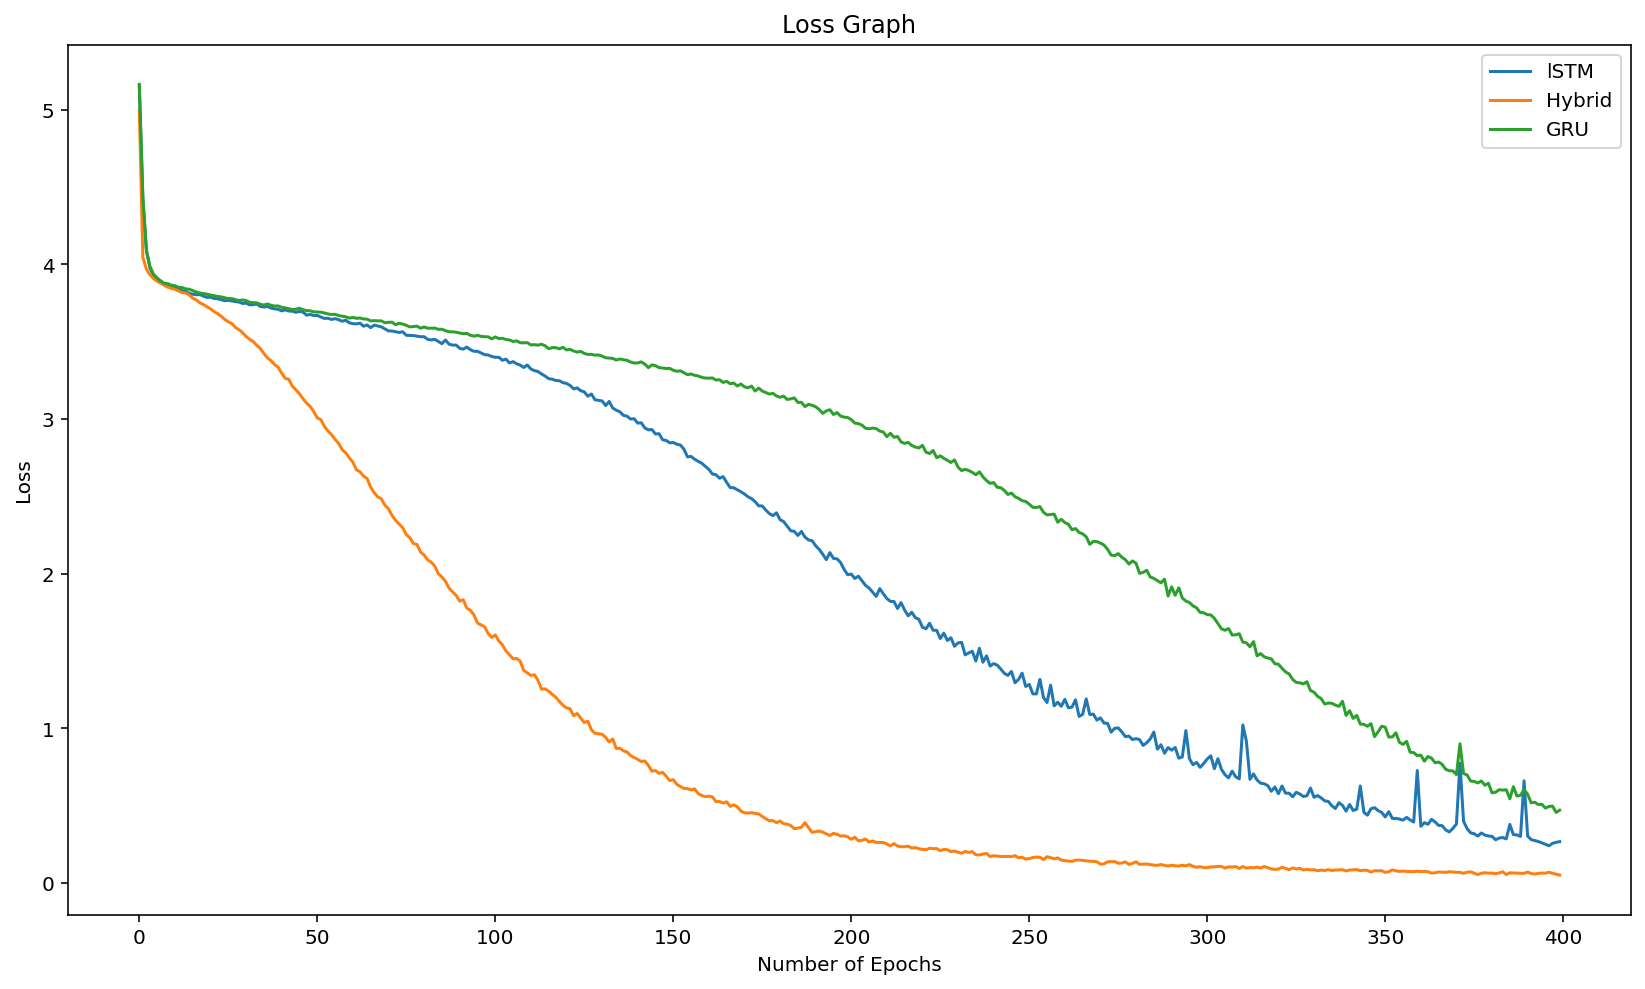

In [5]:
# Plot of loss

plt.figure(figsize=(14,8))
plt.plot(df1["losslstm"],label = "lSTM")
plt.plot(df2["losshybrid"],label = "Hybrid")
plt.plot(df3["lossgru"],label = "GRU")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.savefig("loss.jpg")


plt.show()

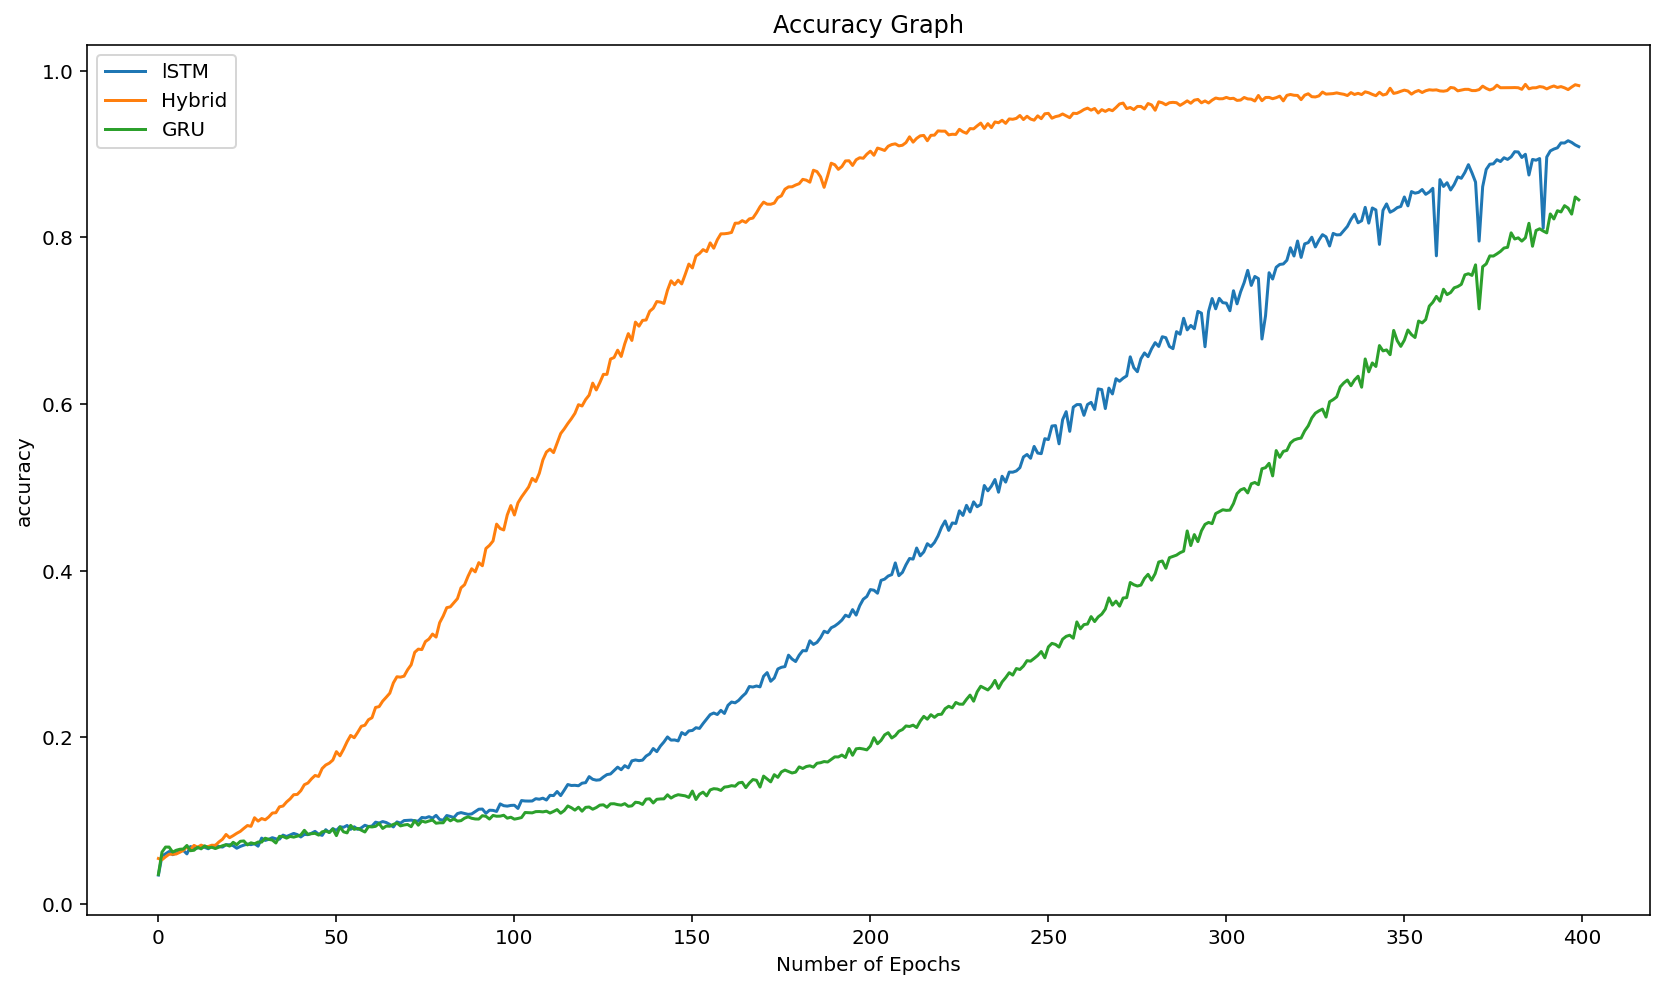

In [6]:
#Plot of Accuracy
plt.figure(figsize=(14,8))
plt.plot(df1["accuracylstm"],label = "lSTM")
plt.plot(df2["accuracyhybrid"],label = "Hybrid")
plt.plot(df3["accuracygru"],label = "GRU")


plt.xlabel("Number of Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.savefig("accuracy.jpg")


plt.show()

### PREDICTIONS

In [6]:
#Load Model
from keras.models import load_model
from sklearn.metrics import classification_report


model = load_model("/home/sparkbrains/Deepti/weights_GRU.h5")
Y_pred = model.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))





2023-01-05 10:48:27.198852: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-05 10:48:27.198871: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sparkbrainsacer): /proc/driver/nvidia/version does not exist
2023-01-05 10:48:27.199086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


74/74 [==============================] - 5s 67ms/step
              precision    recall  f1-score   support

           0       0.44      0.71      0.55        17
           1       0.00      0.00      0.00         1
           2       0.67      1.00      0.80         2
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       1.00      0.50      0.67         2
          11       0.29      0.18      0.22        11
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         3
          14       0.50      1.00      0.67         2
          15       0.50      0.33      0.40         3
          16       0.00      0.00      0.00         2
          17       1.00      0.50      0.67         2
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         1
          21       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# Model Testing

In [7]:
# Dump int_to_note file of Model
import pickle
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
int_to_note
with open('/home/sparkbrains/Deepti/saved_int_to_note.pkl', 'wb') as f:
    pickle.dump(int_to_note, f)


In [8]:

def create_notes(file):
    notes=[]
    #generate notes from sample file
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
        print(note_to_parse)
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [9]:
# read sample file for craete notes
notes= create_notes("/home/sparkbrains/Deepti/Aja.mid")
# unique notes
n_vocab= len(set(notes))
print(n_vocab)
# get all pitch names
pitchnames = sorted(set(item for item in notes))
print(pitchnames)

21
['0.3', '0.4.7', '1.4', '10.1', '11.2', '11.2.6', '2.6', '2.6.9', '4.7.11', '5.7.0', '7.11', '7.11.2', '9.0.4', '9.1', '9.11.2', 'B-3', 'B3', 'C#4', 'E-4', 'E4', 'G#3']


In [10]:
# function call to create sequence for extracting  network_input and output of sample file 
network_input, network_output = Create_sequence(pitchnames, n_vocab)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(network_input, network_output, test_size= 0.2, random_state= 1)
# Load int_to_note of model 
import pickle
with open('/home/sparkbrains/Deepti/saved_int_to_note.pkl', 'rb') as f:
    int_to_note = pickle.load(f)

In [11]:
#predict  notes
def generate_notes(model, network_input, pitchnames, n_vocab, i):
    """ Generate notes from the neural network based on a sequence of notes """
    start = np.random.randint(0, len(network_input)-1)

    

    pattern = network_input[start]
    prediction_output = []
    for note_index in range(i):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input 

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        if index == pattern[-1] and index== pattern[-2]:
            index = np.random.randint(0,n_vocab-1)
        
        result = int_to_note[index]
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [12]:
## Variable length output
variable_lenght_output = int(input())
prediction_output= generate_notes(model, network_input, pitchnames, n_vocab, variable_lenght_output )

500


In [13]:
# MUlti - instruments
def add_instruments(m):
    offset = 0
    output_notes = []
    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                for i in m:
                    if i == 'Piano':
                        output_notes.append(instrument.Piano())
                    if i == 'ElectricGuitar':
                        output_notes.append(instrument.ElectricGuitar())
                       
                    if i == 'Percussion':
                        output_notes.append(instrument.Percussion())
                        
                    if i == 'AcousticBass':
                        output_notes.append(instrument.AcousticBass())
                    if i =="Flute":
                        output_notes.append(instrument.Flute())
                    if i == "Violin":
                        output_notes.append(instrument.Violin())
                    if i == "Choir":
                        output_notes.append(instrument.Choir())
                    if i == "StringInstrument":
                        output_notes.append(instrument.StringInstrument())
                    if i == "BassDrum":
                        output_notes.append(instrument.BassDrum())
                    if i == "ElectricPiano":
                        output_notes.append(instrument.ElectricPiano())
                    if i == "Harp":
                        output_notes.append(instrument.Harp())
                    if i == "Guitar":
                        output_notes.append(instrument.Guitar())
                    if i == "Trumpet":
                        output_notes.append(instrument.Trumpet())
                    if i == "Organ":
                        output_notes.append(instrument.Organ())
                    if i == "ElectricOrgan":
                        output_notes.append(instrument.ElectricOrgan())
                    if i == "AcousticPiano":
                        output_notes.append(instrument.AcousticPiano())
                cn=int(current_note) 
                new_note=note.Note(cn)
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            for i in m:
                    if i == 'Piano':
                        output_notes.append(instrument.Piano())
                    if i == 'ElectricGuitar':
                        output_notes.append(instrument.ElectricGuitar())   
                    if i == 'Percussion':
                        output_notes.append(instrument.Percussion())
                        
                    if i == 'AcousticBass':
                        output_notes.append(instrument.AcousticBass())
                    if i =="Flute":
                        output_notes.append(instrument.Flute())
                    if i == "Violin":
                        output_notes.append(instrument.Violin())
                    if i == "Choir":
                        output_notes.append(instrument.Choir())
                    if i == "StringInstrument":
                        output_notes.append(instrument.StringInstrument())
                    if i == "BassDrum":
                        output_notes.append(instrument.BassDrum())
                    if i == "ElectricPiano":
                        output_notes.append(instrument.ElectricPiano())
                    if i == "Harp":
                        output_notes.append(instrument.Harp())
                    if i == "Guitar":
                        output_notes.append(instrument.Guitar())
                    if i == "Trumpet":
                        output_notes.append(instrument.Trumpet())
                    if i == "Organ":
                        output_notes.append(instrument.Organ())
                    if i == "ElectricOrgan":
                        output_notes.append(instrument.ElectricOrgan())
                    if i == "AcousticPiano":
                        output_notes.append(instrument.AcousticPiano())
                   


            new_note = note.Note(pattern)
            new_note.offset = offset

            output_notes.append(new_note)
     # output_notes
    midi_stream = stream.Stream()
    # adding melody at begining
    name1 = notes[0]
    name1.quarterLength= 2.0
    midi_stream.append(name1)
    midi_stream.repeatAppend(name1, 2)
   
    midi_stream.append(output_notes)

    
    midi_stream.insert(0, tempo.MetronomeMark(number=90)) #take any value from list [10,20, 30, 40,50,60,70,90, 100.....150] to add dynamic tempo
#    adding melody at end
#     name2= notes[-1]
#     name2.quarterLength= 2.0
#     midi_stream.append(name2)
#     midi_stream.repeatAppend(name2, 2)
    music_generate= midi_stream.write('midi', fp='musicmultiinstruments2_gru.mid')
    return music_generate, output_notes

In [14]:
def option():
    
   
    '''User_input- user choice instruemnt 
    Multi_instruments- all instruments in input music file'''
    
    option= input("User_input| Multi_instruemnts")
    if option== "User_input":
        double_list= []
        User_input= input()
        double_list.append(User_input)

        music_generate, output_notes= add_instruments(double_list)
        
    elif option== "Multi_instruments":
        import music21
        import re

        from music21 import converter, instrument, note, chord
        file = '/home/sparkbrains/Deepti/Aja.mid'
        midi = converter.parse(file)  #read file
        parts = instrument.partitionByInstrument(midi)
        Instr= []
        li=[]
        value_list = list()
        for i in parts:
            ins_1 = i.getInstrument()
            li.append(ins_1)

        double_list = list()
        for hth in li:
            aa  = str(hth).replace(" ", "")
            double_list.append(aa)
        
       

        m=[]
        for i in double_list:
            if len(i.split(":"))== 2:
                m.append(i.split(":")[1])
    
            else:
                m.append(i)



        music_generate, output_notes= add_instruments(m)
    return music_generate, output_notes

In [15]:
# function call for adding instruemnts in output_notes
option()

User_input| Multi_instruemntsMulti_instruments


('musicmultiinstruments2_gru.mid',
 [<music21.instrument.ElectricGuitar 'Electric Guitar'>,
  <music21.instrument.ElectricPiano 'Electric Piano'>,
  <music21.instrument.Piano 'Piano'>,
  <music21.instrument.Percussion 'Percussion'>,
  <music21.chord.Chord B>,
  <music21.instrument.ElectricGuitar 'Electric Guitar'>,
  <music21.instrument.ElectricPiano 'Electric Piano'>,
  <music21.instrument.Piano 'Piano'>,
  <music21.instrument.Percussion 'Percussion'>,
  <music21.note.Note F>,
  <music21.instrument.ElectricGuitar 'Electric Guitar'>,
  <music21.instrument.ElectricPiano 'Electric Piano'>,
  <music21.instrument.Piano 'Piano'>,
  <music21.instrument.Percussion 'Percussion'>,
  <music21.note.Note F>,
  <music21.instrument.ElectricGuitar 'Electric Guitar'>,
  <music21.instrument.ElectricPiano 'Electric Piano'>,
  <music21.instrument.Piano 'Piano'>,
  <music21.instrument.Percussion 'Percussion'>,
  <music21.note.Note G>,
  <music21.instrument.ElectricGuitar 'Electric Guitar'>,
  <music21.ins

In [16]:
#spectrogram
#convert midi file into wav file
!pip install fluidsynth
import fluidsynth
!pip install midi2audio
from midi2audio import FluidSynth
fs = FluidSynth()
fs.midi_to_audio('/home/sparkbrains/Deepti/musicmultiinstruments2_gru.mid', 'output2_multi_gru.wav')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/sparkbrains/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'output2_multi_gru.wav'..


In [17]:
# read wav file
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
# read wav file
FRAME_SIZE = 2048
HOP_SIZE = 512
scale_file = "/home/sparkbrains/Deepti/output2_multi_gru.wav"

scale, sr = librosa.load(scale_file)
S_scale = librosa.stft(scale, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

S_scale.shape
type(S_scale[0][0])
Y_scale = np.abs(S_scale) ** 2
Y_scale.shape
type(Y_scale[0][0])

numpy.float32

In [18]:
#plot spectrogrma
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    
    plt.colorbar(format="%+2.f")
    plt.savefig('spec2_multi_gru.jpg')

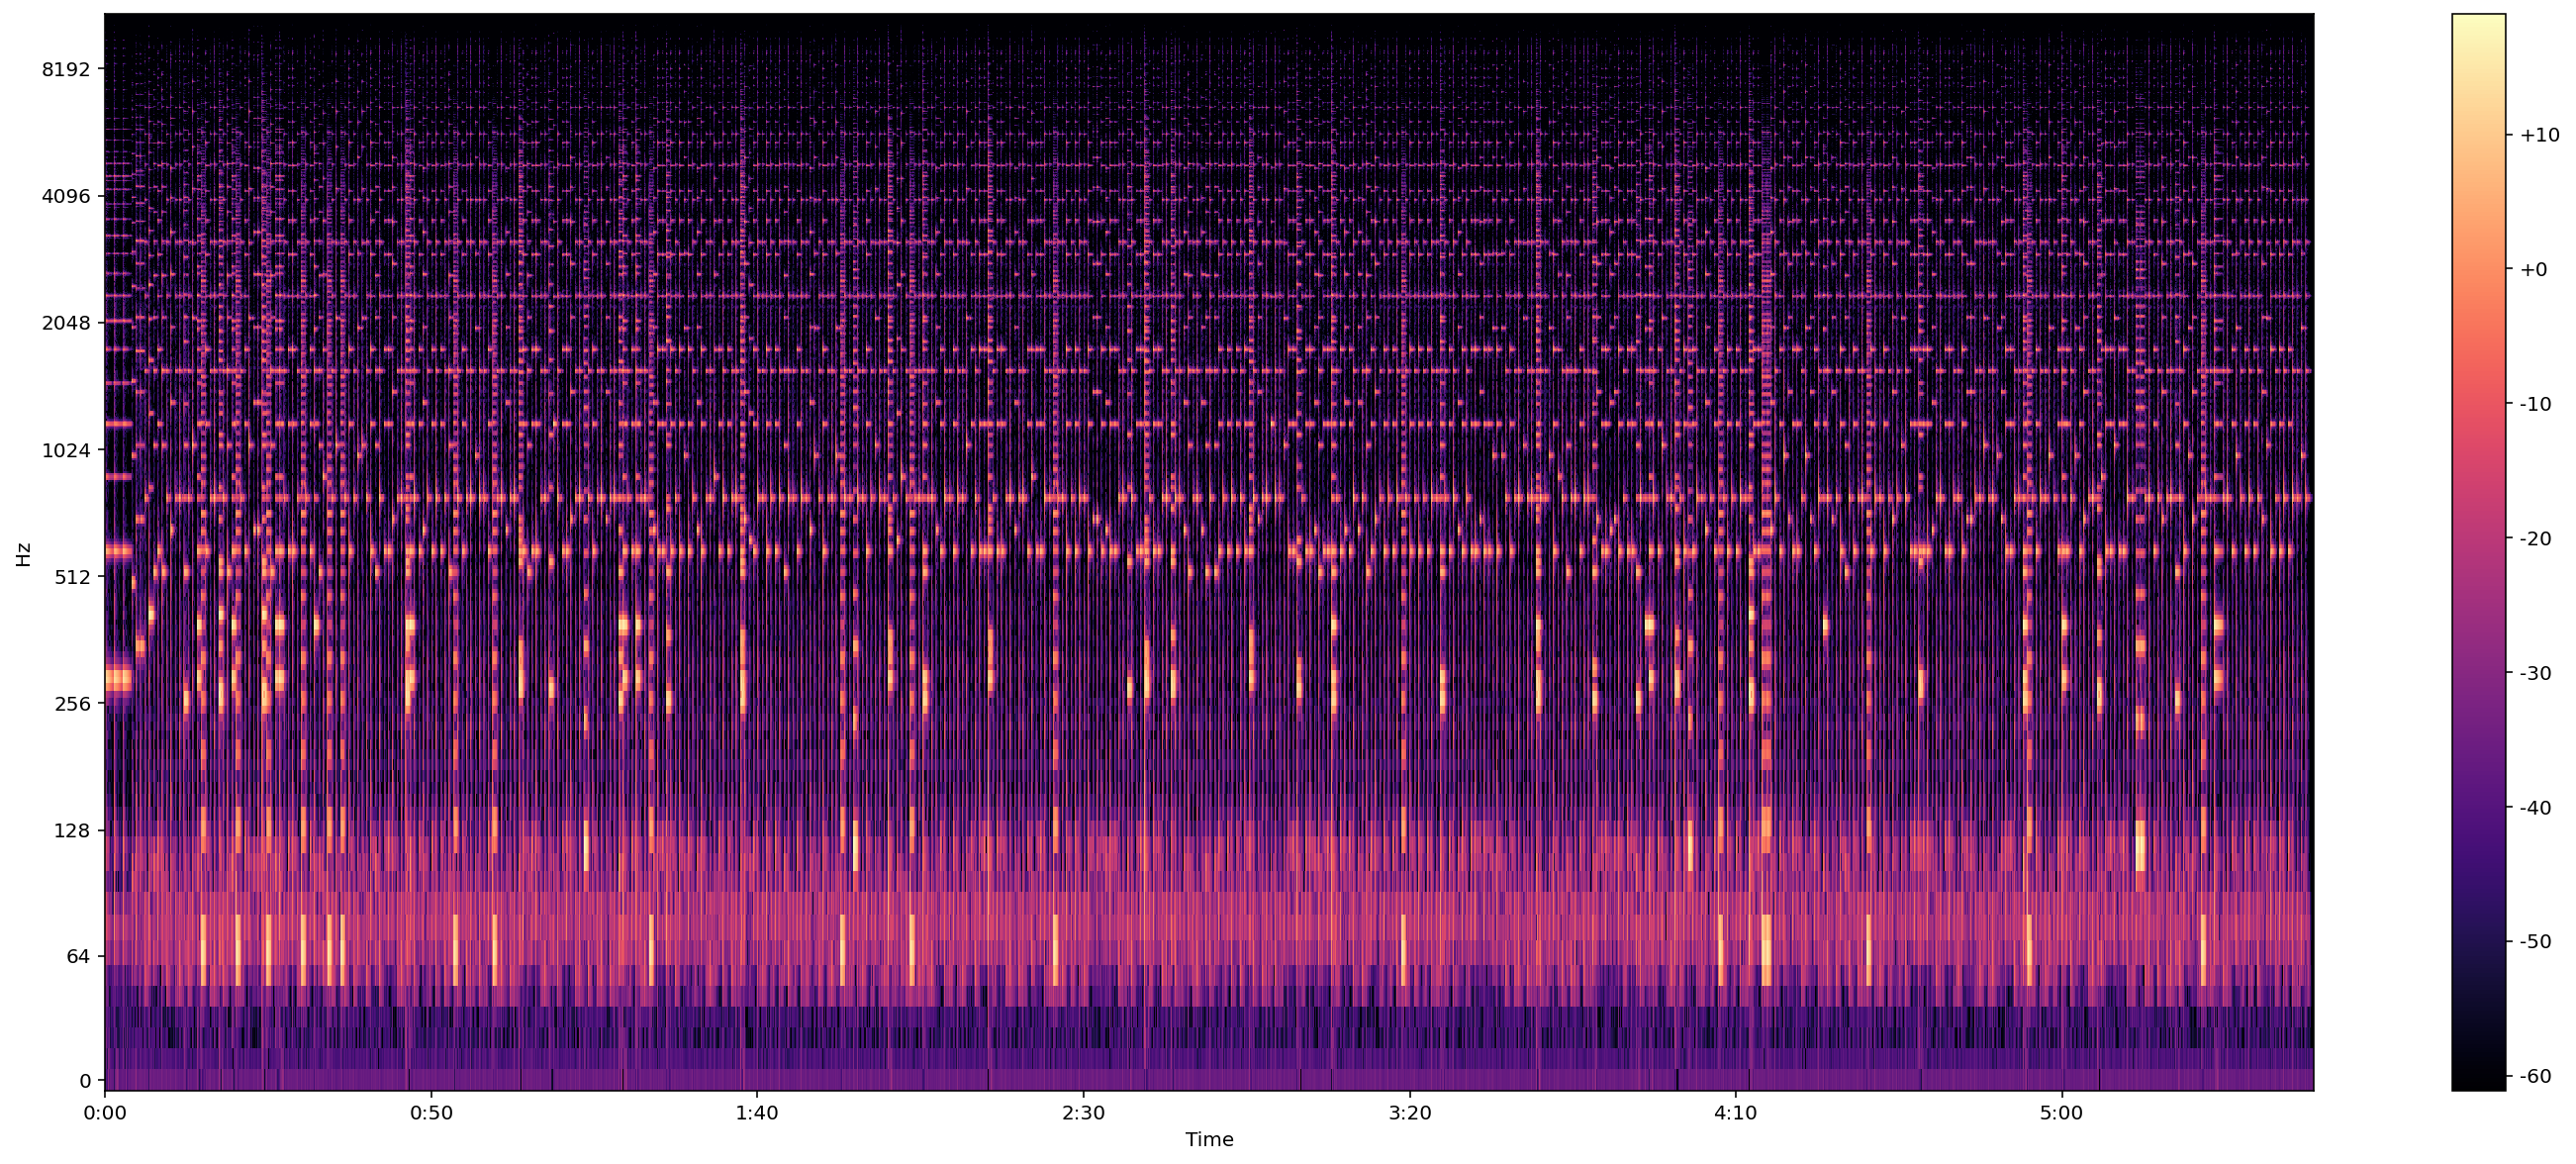

In [19]:
Y_log_scale = librosa.power_to_db(Y_scale)
plot_spectrogram(Y_log_scale, sr, HOP_SIZE, y_axis="log")